<a href="https://colab.research.google.com/github/goodu001/1000_flights_project/blob/main/1000_flight2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     FlightID FlightNumber Date_Local Departure_Local Arrival_Local Date_UTC  \
1000    RG559   2025-01-18       7:30           15:15    2025-01-18     1:30   
1001    RG891   2025-06-16       8:15           11:15    2025-06-16     1:15   
1002    RG967   2025-06-06       9:45           14:45    2025-06-06     2:45   
1003    RG611   2025-03-16       9:15           22:30    2025-03-16     1:15   
1005    RG212   2025-01-19      14:45            3:15    2025-01-19     7:45   

     Departure_UTC Arrival_UTC Origin Destination Aircraft ULD_Details  \
1000          8:15         SIN    DXB        B737   AKE×17      P1P×12   
1001          2:15         SYD    LAX        B787    RKN×9           9   
1002          8:45         SIN    LHR        A380   AKE×12       RKN×3   
1003         15:30         HND    JFK        A350    PMC×1           1   
1005         20:15         LHR    LAX        B787   AKE×17          17   

     Total_ULDs     Status  
1000         29  Cancelled  
1001  Cancelled 

/tmp/ipython-input-14-3728309714.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date_Local'] = pd.to_datetime(df['Date_Local'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with 

Random Forest Results:
MAE: 6.60
MSE: 59.41
R2: 0.02



/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Gradient Boosting Results:
MAE: 5.99
MSE: 52.14
R2: 0.14

Linear Regression Results:
MAE: 10.77
MSE: 177.93
R2: -1.92



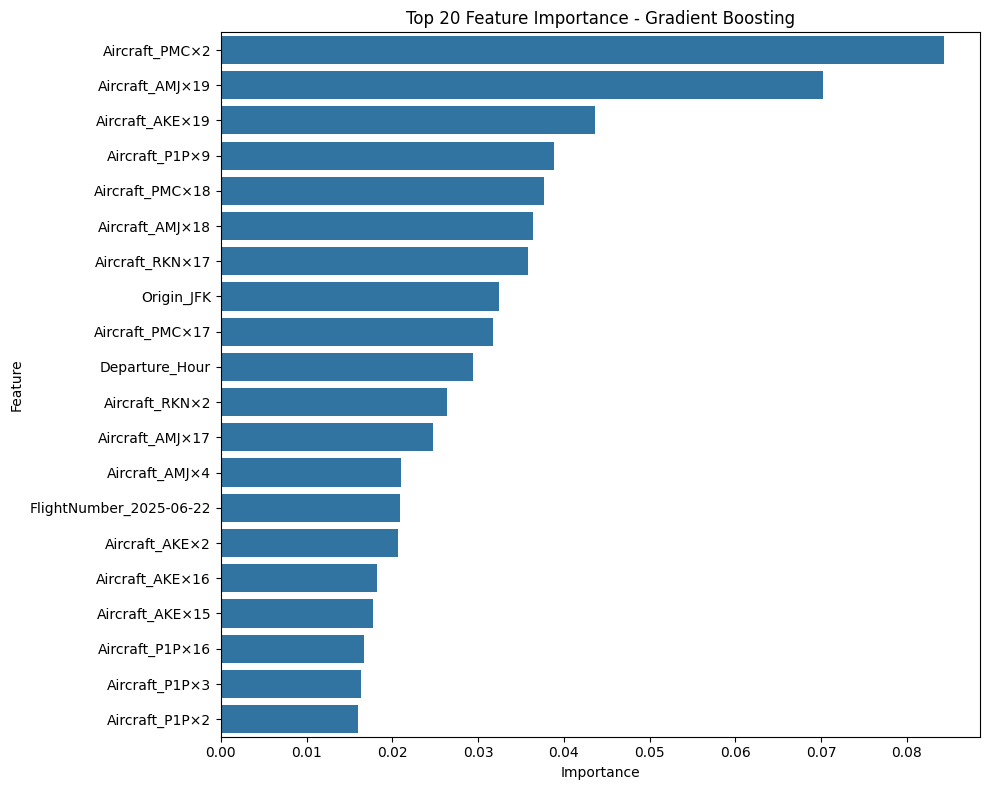

Predicted ULDs: 21


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Flight_Duration']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder # OneHotEncoder added here
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

path = "/content/drive/MyDrive/flight 1000.csv"
# Load the data
# Added error_bad_lines=False to handle potential parsing issues
df = pd.read_csv(path, on_bad_lines='skip', engine='python')

# Data Exploration
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Feature Engineering
# Extract hour from departure time
def extract_hour(time_str):
    try:
        return int(time_str.split(':')[0])
    except:
        return np.nan

df['Departure_Hour'] = df['Departure_Local'].apply(extract_hour)

# Extract month from date
df['Date_Local'] = pd.to_datetime(df['Date_Local'], errors='coerce')
df['Month'] = df['Date_Local'].dt.month

# Calculate flight duration in hours
def calculate_duration(dep, arr):
    try:
        dep_h, dep_m = map(int, dep.split(':'))
        arr_h, arr_m = map(int, arr.split(':'))
        return (arr_h - dep_h) + (arr_m - dep_m)/60
    except:
        return np.nan

df['Flight_Duration'] = df.apply(lambda x: calculate_duration(x['Departure_Local'], x['Arrival_Local']), axis=1)

# Process ULD_Details to extract total ULDs (as a sanity check)
def parse_uld_details(uld_str):
    if pd.isna(uld_str):
        return 0
    parts = uld_str.split(',')
    total = 0
    for part in parts:
        if '×' in part:
            count = part.split('×')[-1]
            try:
                total += int(count)
            except:
                pass
        else: # Handle cases where there is no '×' and just a number
             try:
                 total += int(part)
             except:
                 pass

    return total

df['Calculated_ULDs'] = df['ULD_Details'].apply(parse_uld_details)

# Convert 'Total_ULDs' to numeric, coercing errors to NaN
df['Total_ULDs'] = pd.to_numeric(df['Total_ULDs'], errors='coerce')

# Drop rows where 'Total_ULDs' is NaN
df.dropna(subset=['Total_ULDs'], inplace=True)

# Check if Total_ULDs matches our calculation (only for rows where Total_ULDs was numeric)
print("Mismatch between Total_ULDs and calculated:", sum(df['Total_ULDs'] != df['Calculated_ULDs']))


# Feature Selection
features = ['FlightNumber', 'Departure_Hour', 'Month', 'Flight_Duration',
            'Origin', 'Destination', 'Aircraft', 'Status']
target = 'Total_ULDs'

# Preprocessing
# Separate features and target
X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['Departure_Hour', 'Month', 'Flight_Duration']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['FlightNumber', 'Origin', 'Destination', 'Aircraft', 'Status']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Model Building
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'Model': pipeline
    }

    print(f"{name} Results:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2: {r2:.2f}\n")

# Feature Importance for the best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['Model']

# Get feature names after preprocessing
preprocessor = best_model.named_steps['preprocessor']

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get the regressor
    regressor = best_model.named_steps['regressor']

    # Get feature names after one-hot encoding
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)

    # Combine all feature names
    all_feature_names = numeric_features + list(cat_feature_names)

    # Get feature importances
    importances = regressor.feature_importances_

    # Make sure lengths match
    if len(all_feature_names) != len(importances):
        print(f"Warning: Feature names count ({len(all_feature_names)}) doesn't match importance values count ({len(importances)})")
        # Take only the first n features that match importance values
        all_feature_names = all_feature_names[:len(importances)]

    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature',
                data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Save the best model
joblib.dump(best_model, 'flight_uld_predictor.pkl')

# Example prediction function
def predict_ulds(flight_data):
    """Predict ULDs for new flight data"""
    model = joblib.load('flight_uld_predictor.pkl')

    # Convert input to DataFrame
    input_df = pd.DataFrame([flight_data])

    # Make prediction
    prediction = model.predict(input_df)

    return prediction[0]

# Example usage
example_flight = {
    'FlightNumber': 'RG123',
    'Departure_Hour': 10,
    'Month': 6,
    'Flight_Duration': 8.5,
    'Origin': 'SIN',
    'Destination': 'LAX',
    'Aircraft': 'B787',
    'Status': 'Scheduled'
}

predicted_ulds = predict_ulds(example_flight)
print(f"Predicted ULDs: {predicted_ulds:.0f}")